In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import torch
import lightning as L
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import seaborn as sns
from torchvision import transforms
from lightning.pytorch.loggers import CSVLogger

sys.path.append('../source')

from utils import *
from data import *
from model import *

In [2]:
data_root = '../../data/super_baseline'
dataset = LSTDataset(
    os.path.join(data_root, 'ground_truth'), 
    os.path.join(data_root, 'samples'),
    os.path.join(data_root, 'collection.csv')
    )

In [3]:
input_size = (32, 32)
split = [0.8, 0.1, 0.1]
batch_size = 16

generator1 = torch.Generator().manual_seed(42)
train_loader, valid_loader, test_loader = torch.utils.data.random_split(dataset, split, generator=generator1)
train_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_loader, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=len(test_loader))

In [4]:
if torch.cuda.is_available():
  device = torch.device(torch.cuda.current_device())
else:
  device = torch.device("cpu")

model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=1
    ).to(device)

loss_fn = F.mse_loss
lr = 1*(10**-3)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
modis_model = ModisNet(model=model, optimizer=optimizer, loss_fn=loss_fn)

In [5]:
exp_name = 'baseline'
epochs = 30

logger = CSVLogger('logs', name=exp_name)
logger.log_hyperparams({'epochs': epochs, 'loss_fn': str(loss_fn), 'lr': lr, 'optimizer': str(optimizer)})

trainer = L.Trainer(max_epochs=epochs, logger=logger, log_every_n_steps=5)
trainer.fit(model=modis_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

/nfshomes/ayang115/miniconda3/envs/inpaint/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfshomes/ayang115/miniconda3/envs/inpaint/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.720    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [6]:
log_path = os.path.join('logs', exp_name)
latest_log = sorted(os.listdir(log_path), key=lambda x: x.split('_')[1])[-1]
print(latest_log)
losses = pd.read_csv(os.path.join(log_path, latest_log, 'metrics.csv'))
losses.bfill(inplace=True)
losses.ffill(inplace=True)

version_6


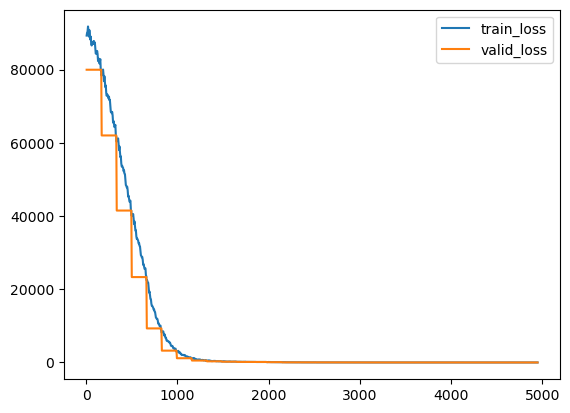

In [7]:
plt.plot(losses['step'], losses['train_loss'], label='train_loss')
plt.plot(losses['step'], losses['valid_loss'], label='valid_loss')
plt.legend()

In [9]:
modis_model.eval()
losses = trainer.test(model=modis_model, dataloaders=train_loader)

/nfshomes/ayang115/miniconda3/envs/inpaint/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfshomes/ayang115/miniconda3/envs/inpaint/lib/pytho ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.9140446186065674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Text(0.5, 1.0, 'Predicted')

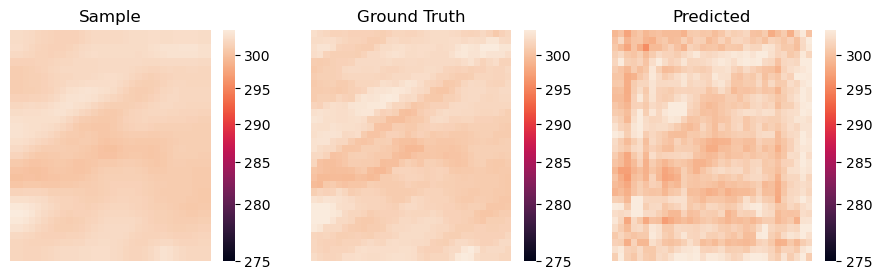

In [10]:
import matplotlib.colors as colors
sample, img = dataset[np.random.randint(len(dataset))]
sample = torch.from_numpy(sample.reshape(1, 1, 32, 32)).type(torch.FloatTensor)
img = torch.from_numpy(img.reshape(1, 1, 32, 32)).type(torch.cuda.FloatTensor)
pred = modis_model.forward(sample)

img, sample = np.array(img.detach().cpu()).reshape(32, 32), np.array(sample.detach().cpu()).reshape(32, 32)
pred = np.array(pred.detach().cpu()).reshape(32, 32)
cmap = sns.color_palette(
    'rocket', as_cmap=True
)
norm = colors.PowerNorm(gamma=0.8, vmin = 275, vmax=np.max(sample))

fig, axs = plt.subplots(1, 3, figsize=(11, 3))
sns.heatmap(sample, ax=axs[0], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[0].set_title('Sample')

sns.heatmap(img, ax=axs[1], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[1].set_title('Ground Truth')

sns.heatmap(pred, ax=axs[2], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[2].set_title('Predicted')


In [11]:
torch.save({
    'epoch': trainer.current_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
    os.path.join(log_path, latest_log, 'checkpoints', 'epochs={}'.format(trainer.current_epoch))
    )

In [12]:
path = os.path.join(log_path, latest_log, 'checkpoints', 'epochs={}'.format(trainer.current_epoch))

In [13]:
os.path.exists(path)

True

In [14]:
path

'logs/baseline/version_6/checkpoints/epochs=30'